In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec
import seaborn as sns
from datetime import datetime,date
from IPython.display import display
%matplotlib inline

In [3]:
fb_data = pd.read_csv('/Users/guest/Dropbox/Education/Thinkful/Unit 1/Lesson 3 (Intermediate Data Viz)/u1l5/facebook-fact-check.csv')

In [4]:
fb_data['Date Published'] = fb_data['Date Published'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
fb_data ['Date Published'] = fb_data['Date Published'].map(lambda x:x.date())

In [5]:
fb_data = fb_data.replace('mixture of true and false', 'mostly or partially false')
fb_data = fb_data.replace('mostly false', 'mostly or partially false')

# Recode false and non-false classifications as 1s and 0s in an additional column for later use
def recode_rating(row):
    if row == 'mostly true':
        return 0
    if row == 'mostly or partially false':
        return 1
    if row == 'no factual content':
        return 0
    else:
        return np.nan
fb_data['rating_recode'] = fb_data['Rating'].apply(lambda x: recode_rating(x))

In [6]:
# Set aesthetics
sns.set_style("whitegrid")

rating_order = ['mostly true','mostly or partially false','no factual content']

date_labels = ['2016-09-19', '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-26', '2016-09-27']

color_order = ['#47C476','#C44747','#47A6C4']

category_order = ['mainstream', 'left', 'right']

category_colors = ['#C959AE', '#47A6C4','#C44747']

In [7]:
# Create slice for analysis
truth_ratings = list(fb_data['Rating'].unique())
summary_frame = pd.DataFrame(columns=['rating','share_count','reaction_count','comment_count'])
    
for rating in truth_ratings:
    data_slice = fb_data[fb_data.Rating==rating][['Date Published','share_count','reaction_count','comment_count']].groupby('Date Published').mean()
    data_slice['x_loc'] = (np.arange(1,8))
    data_slice['rating'] = [rating] * 7
    summary_frame = pd.concat([summary_frame, data_slice])

summary_frame.reset_index(level=0, inplace=True)
summary_frame.rename(columns = {'index':'date'}, inplace = True)

In [8]:
dist_slice = fb_data[['Rating', 'share_count', 'reaction_count', 'comment_count']].copy().groupby('Rating').sum()
dist_slice.reset_index(level=0, inplace=True)
dist_slice.rename(columns = {'index':'rating'}, inplace = True)



def millions(x, pos):
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)



def plot_dist(variable, var_name, cut):
    
    cutoff = fb_data[variable].quantile(q=cut)

    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7,1], height_ratios=[1])
 
    ax1 = plt.subplot(gs[0])
    sns.violinplot(y='Rating',
                       x=variable, 
                       data=fb_data,
                       palette=sns.color_palette(color_order), 
                       hue_order=rating_order, 
                       order=rating_order,
                       scale='count',
                       cut=0)
    
    sns.stripplot(y='Rating',
                  x=variable,
                  data=fb_data,
                  hue='Rating',
                  palette=sns.color_palette(color_order), 
                  hue_order=rating_order, 
                  order=rating_order,
                  jitter=0.3,
                  size=3,
                  alpha=0.65,
                  zorder=0)

    
    leg = ax1.legend(loc='upper center',
                     bbox_to_anchor=(0.907, 1.1),
                     ncol=1, 
                     frameon=True, 
                     framealpha=0.6)
    leg.set_title('Truth Rating',prop={'size':12})


    ax1.set_xlim(0,cutoff)
    ax1.set_xlabel('Number of ' + var_name)
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax1.yaxis.tick_right()
    ax1.set_yticklabels([])
    ax1.set_ylabel('Truth Rating')
    ax1.set_title(get_fignum() + 'Distribution of ' + var_name + ' by Truth Rating\n')

    
    ax2 = plt.subplot(gs[1])
    g = sns.barplot(x='Rating', 
                    y=variable, 
                    data=dist_slice,
                    palette=sns.color_palette(color_order), 
                    hue_order=rating_order, 
                    order=rating_order)
    
    ax2.set_xticklabels([])
    ax2.set_xlabel('')
    ax2.get_yaxis().set_major_formatter(formatter)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Total ' + var_name + ' (in millions)')
    ax2.set_title(get_fignum() + 'Count of ' + var_name + '\nby Truth Rating')
    
    
    plt.tight_layout()
    plt.show()

In [9]:
def get_cutoff(variable, cut):
    cutoff = fb_data[variable].quantile(q=cut)
    cutoff = fb_data[fb_data[variable] >= cutoff].copy()[['Page','Rating','Date Published',variable, 'Post URL']].sort_values(by=variable, ascending=False)
    display(cutoff)

In [10]:
def timeplot(variable, var_name):

    fig = plt.figure(figsize=(12,4))
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[7,1], height_ratios=[1])

    
    ax1 = plt.subplot(gs[0])
    g = sns.factorplot(x="x_loc", 
                   y=variable, 
                   hue="rating",
                   hue_order=rating_order,
                   palette=sns.color_palette(color_order), 
                   data=summary_frame,
                   ax=ax1)
    
    ax1.set_xticklabels(date_labels)
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax1.set_xlabel('Date Posted')
    ax1.set_ylabel('Average Number of ' + var_name)
    ax1.set_title(get_fignum() + 'Average ' + var_name + ' by Truth Rating & Date of Post')

    plt.close(g.fig)

    
    ax2 = plt.subplot(gs[1])
    g = sns.factorplot(x="rating", 
                   y=variable, 
                   legend=False, 
                   palette=sns.color_palette(color_order), 
                   hue_order=rating_order, 
                   order=rating_order, 
                   data=summary_frame, 
                   ax=ax2)
    
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.yaxis.tick_right()
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_title('Overall')
    plt.close(g.fig)

    
    plt.tight_layout()
    plt.show()

In [11]:
def get_prop(category, rating):
    prop_slice = fb_data[fb_data.Category == category]
    denom = prop_slice.shape[0]
    num = prop_slice[prop_slice.Rating == rating].shape[0]
    return num/denom

c_categories = []
c_ratings = []
c_props = []

for cat in fb_data['Category'].unique():
    c_categories = c_categories + [cat] * 3
    for rating in fb_data['Rating'].unique():
        c_props.append(get_prop(cat, rating))
        c_ratings.append(rating)

comp_dict = {'category':c_categories,
              'rating':c_ratings,
              'proportion':c_props}
    
comp_frame = pd.DataFrame(comp_dict)

In [12]:
fignum = 0

def get_fignum():
    global fignum 
    fignum = fignum + 1
    return 'Figure ' + str(fignum) + '.\n'

# Analysis of the impact of factual content of news stories on their Facebook proliferation & research proposal for a hypothetical intervention

<br><br>

## 1. Background analysis: are Facebook interactions impacted by the truthfulness of a post?



### 1a. Data Utilized

Buzzfeed News selected nine verified Facebook pages and tracked every news item they posted over the same one-week period. Three of these pages were classified as mainstream (*Politico, CNN Politics, and ABC News Politics*), three as left-wing hyperpartisan (*The Other 98%, Addicting Info, and Occupy Democrats*), and three as right-wing hyperpartisan (*Eagle Rising, Right Wing News, and Freedom Daily*).

Each post made by these nine pages over the week of 9/19/16 was rigorously fact-checked and classified by Buzzfeed News as either mostly true, mostly false, or a mixture of true and false. Posts that contained no factual claims, such as opinion pieces, were classified as having no factual content. At the end of the week, data was simultaneously collected on the number of times that each post was shared, commented on, or liked/reacted to.

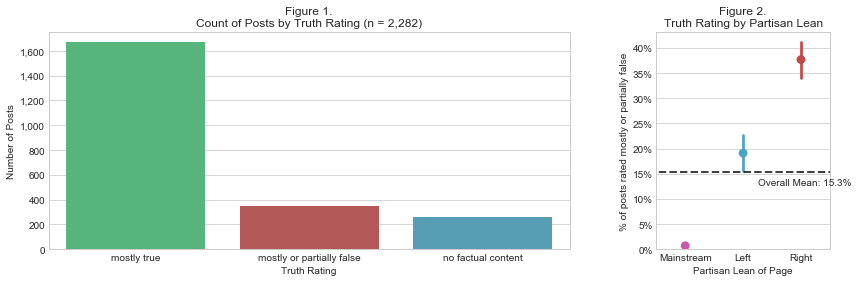

In [13]:
fig = plt.figure(figsize=(14,4))
    
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1], height_ratios=[1])
gs.update(wspace=.25)


ax1 = plt.subplot(gs[0])
g = sns.countplot(fb_data['Rating'],
             palette=sns.color_palette(color_order), 
                   order=rating_order)

ax1.set_title(get_fignum() + 'Count of Posts by Truth Rating (n = 2,282)')
ax1.set_ylabel('Number of Posts')
ax1.set_xlabel('Truth Rating')
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


ax2 = plt.subplot(gs[1])
g = sns.pointplot(x='Category',
              y='rating_recode',
              palette=sns.color_palette(category_colors),
              data=fb_data, ci=95,
              join=False)

overall_rating_mean = fb_data['rating_recode'].mean()
plt.plot([-1, 4],
         [overall_rating_mean, overall_rating_mean], 
         linewidth=2, 
         linestyle='--', 
         color='black', 
         alpha=0.75)
plt.text(x=1.25,
         y=(overall_rating_mean-0.025), 
         s='Overall Mean: ' + str(round(overall_rating_mean*100,1)) + '%')

ax2.set_xticklabels(['Mainstream', 'Left', 'Right'])
ax2.set_xlabel('Partisan Lean of Page')
ax2.set_ylabel('% of posts rated mostly or partially false')
ax2.set_title(get_fignum() + 'Truth Rating by Partisan Lean')

ax2.set_ylim(0,)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.show()

###### Summary of Data (Figure 1)
Of the **2,282** stories posted by these pages over the week of 9/19/16, **1669** (73.1%) were classified by Buzzfeed as mostly true, **245** (10.7%) as a mixture of true and false, **104** (4.6%) as mostly false, and **264** (11.6%) as having no factual claims. Stories that were rated mostly false and stories that contained a mixture of true and false claims have been combined for the purposes of this analysis, totaling **349** news items, or 15.3% of all fact-checked posts 

###### Partisan Lean (Figure 2)
**Mainstream** pages were significantly more likely to post mostly true stories than either left or right-wing hyperpartisan pages – of the **1,145** mainstream posts that Buzzfeed fact-checked, 94.7% were rated as mostly true, 4.5% were rated as having no factual content, and only 0.7% were rated mostly or partially false.

**Left-Wing** hyperpartisan pages made a total of **471** posts over the 7-day study period, and were more likely than mainstream or right-wing outlets to post opinion-driven articles that contained no factual claims (24.6%). 19.1% of the posts made by left-wing hyperpartisan pages were rated as mostly or partially false, and the remaining 56.3% were rated mostly true.

**Right-Wing** hyperpartisan pages were by far the most likely to post articles containing false information – of the 666 right-wing posts Buzzfeed fact-checked, 37.7% were rated mostly or partially false. 14.4% of the posts made by right-wing hyperpartisan pages were rated as containing no factual content, and the remaining 47.9% were rated mostly true.

<br>

### 1b. Shares & Truth Rating

In all, "mostly true" stories were shared a total of __2,736,827__ times over the one-week observation period, while "mostly or partially false" stories were shared __1,592,961__ times and stories containing no factual content were shared a total of __4,617,344__ times. Relative to false and fact-neutral posts, the distribution of shares of "mostly true" stories was positively skewed. Outliers were present across all three categories, most notably a "no factual content" post that was shared over a million times (_Figures 3 & 4_).

On average,"mostly or partially false" stories were shared __4,630.70__ times, significantly more than "mostly true" stories (mean = __1,675.95__), and significantly less than stories containing "no factual content" (mean = __19,648.27__). In general, this pattern held true across all seven days of the observation period (_Figure 5_).

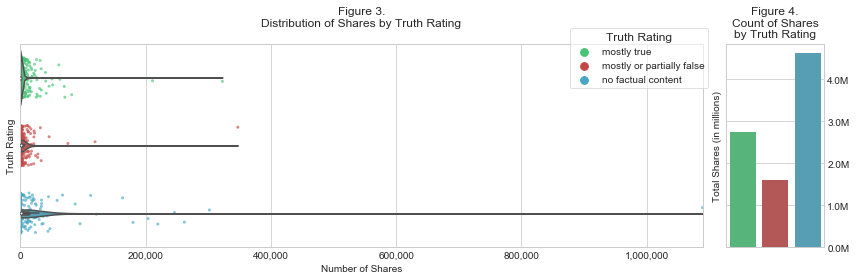

In [14]:
plot_dist('share_count','Shares', 1)

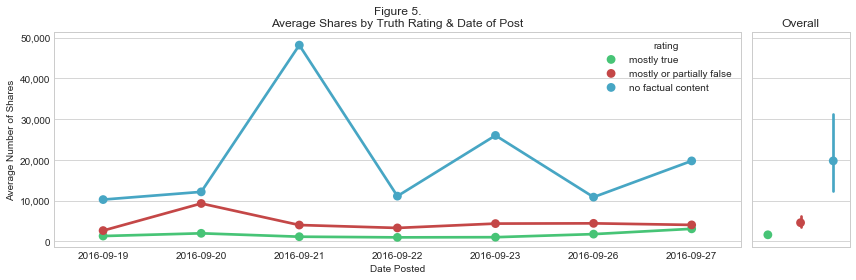

In [15]:
timeplot('share_count', 'Shares')

<br>

### 1c. Reactions & Truth Rating

Over the course of the one week observation period, Facebook users reacted to stories rated "mostly true" __4,941,543__ times, to "mostly or partially false" stories a total of __2,136,209__ times, and to stories rated "no factual content" __5,152,817__ times. Relative to false and fact-neutral posts, the distribution of reactions to "mostly true" stories was positively skewed. Outliers were present across all three categories (_Figures 6 & 7_).

The mean number of reactions to "mostly or partially false" stories over the course of the observation period was __2,964.33__, as compared to a mean of __6,120.94__ for "mostly or partially false" stories and __19,518.24__ for stories rated as having "no factual content." Stories with "no factual content" were reacted to significantly more than both false and mostly true stories, and false stories were reacted to significantly more than mostly true stories (_Figure 8_).

##### Distribution of Reactions by Truth Rating & Total Reactions by Truth Rating


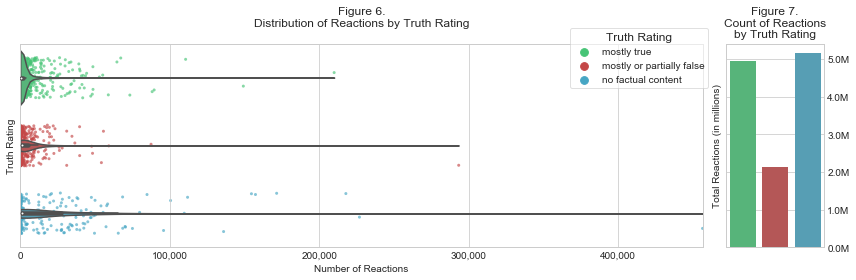

In [16]:
plot_dist('reaction_count', 'Reactions', 1)

##### Mean Reactions by Truth Rating & Date

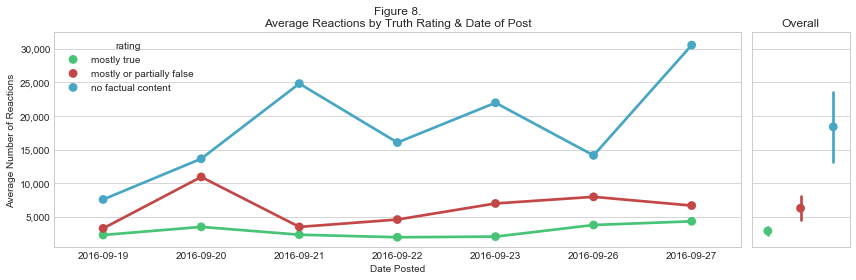

In [17]:
timeplot('reaction_count', 'Reactions')

<br>

### 1d. Comments & Truth Rating

Facebook users commented on stories rated "mostly true" __552,319__ times, on stories rated "mostly or partially false" __236,508__ times, and on stories rated "no factual content" __387,886__ times.  to "mostly or partially false" stories a total of __2,136,209__ times, and to stories rated "no factual content" __5,152,817__ times. Relative to false and fact-neutral posts, the distribution of comments on "mostly true" stories was positively skewed. Outliers were present across all three categories (_Figures 9 & 10_).

The mean number of comments made in response to "mostly or partially false" stories over the course of the observation period was __677.67__, as compared to a mean of __331.33__ for "mostly true" stories and __1,469.27__ for stories rated as having "no factual content." Stories with "no factual content" and stories rated "mostly or partially false" were commented on significantly more than stories rated "mostly true." (_Figure 11_).

##### Distribution of Comments by Truth Rating & Total Comments by Truth Rating

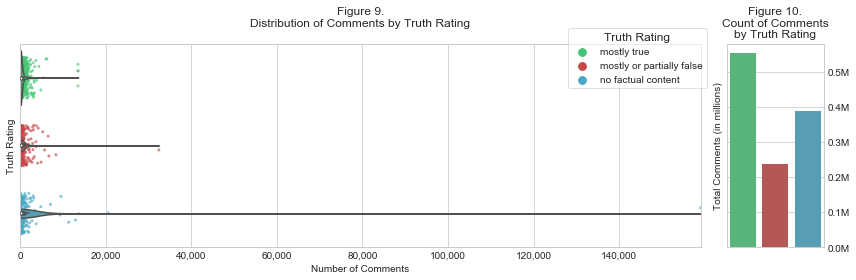

In [18]:
plot_dist('comment_count', 'Comments', 1)

##### Comments by Truth Rating & Date

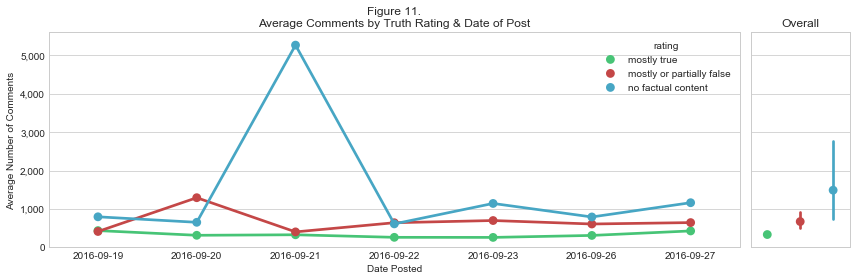

In [19]:
timeplot('comment_count', 'Comments')

<br>

### 1e. Summary of Findings

* __Although news stories rated "mostly true" made up the vast majority of all stories posted, they significantly underperformed in shares, comments, and reactions relative to "mostly or partially false" _and_ "no factual content" stories.__<br><br>

* __Stories rated "mostly or partially false" significantly overperformed relative to "mostly true" stories across shares, comments, and reactions.__ One possible explanation for this is that factually incorrect content, unbound by the rules of factual reporting, is free to be specially designed to proliferate on Facebook.<br><br>

* __Stories rated by Buzzfeed as containing "no factual content" significantly outperformed "mostly true" stories across shares, comments, and reactions. They also outperformed "mostly or partially false" stories across all measures except comments.__ In order to drill down on what types of content attract the most user engagement and what social factors that might reflect, further analysis of the different types of "no factual content" stories (e.g. opinion pieces vs. satire) is recommended.

<br><br>

## 2. Research Proposal

### 2a. The problem & a hypothetical Solution
The fact that stories containing false information significantly outperform true stories on social media currently offers an incentive for pages to generate and share them. In an effort to address this issue, the experiment outlined in this research proposal will test the efficacy of a hypothetical change in Facebook's Timeline algorithm. The goal of this change is to reduce user engagement (shares, reactions, and comments) with fake news stories, thereby reducing their spread and disincentivizing pages from posting them. 

An independent fact-checking team will classify stories posted by the most popular media pages on Facebook using the same methods deployed by Buzzfeed's investigation. The position of links posted by these pages on users' Timelines will be negatively impacted in proportion to the percentage of the page's posts that are classified "Mostly False" or "False." 

### 2b. Hypothesis

User engagement with "mostly or partially false" stories will be lower among users for whom the algorithm change has been applied.

### 2c. Methods & Evaluation Plan

Two comparable, representative samples will be drawn from the overall pool of Facebook users using tools internal to the company. One sample will serve as the control, while the proposed algorithm change will be applied to the other sample. Although click-through rate (CTR) on stories rated "mostly or partially false" was not available to the Buzzfeed researchers, it has strong face validity as a metric of post proliferation and will serve as the variable of interest in this study. Data on shares, comments, and reactions will also be measured to provide additional context.

The trial will take place over three months. If after the three month trial, CTR on "mostly or partially false" posts has decreased by 10% in the experimental condition but _not_ the control conditions, conclude that the intervention is effective. If the CTR on "mostly or partially false" posts is significantly lower (_p < 0.01_) in the experimental condition than in the control condition but has decreased by less than 10%, extend the trial by three months. If CTR on "mostly or partially false" posts does has not decreaseed in the experimental condition by the end of the trial period, remove the algorithm change.

<br><br>

## 3. Bibliography

Silverman, Craig. "Hyperpartisan Facebook Pages Are Publishing False And Misleading Information At An Alarming Rate." Buzzfeed News. https://www.buzzfeed.com/craigsilverman/partisan-fb-pages-analysis (Accessed February 13, 2018)

Singer-Vine, Jeremy. "Fact-Checking Facebook Politics Pages." Github. 
https://github.com/BuzzFeedNews/2016-10-facebook-fact-check (Accessed February 13, 2018)